# The Data Science Pipeline: An Example Using U.S. Airports

## Introduction

Hello and welcome to my tutorial on the Data Pipeline using Python. Before we get started, let's talk about set up. OSX or Linux is highly recommended as it will already have Python installed. I will be using a Jupyter notebook to run the code and include markdown. This is not necessary to follow along, but will make it far easier so I highly recommend it, especially if you are a beginner. You can download it through Anaconda. If you wish to find out more, you can check out Anaconda's site here: http://jupyter.readthedocs.io/en/latest/install.html I am using Python version 3.5.2 and Anaconda Version 4.2.0. You can check your versions by typing "python --version" in a terminal window. Once you have your environment set up, it's time to get the data.

In this tutorial, we will be using the TSA's data from 2014 found here: https://www.dhs.gov/tsa-claims-data

and the FAA's data from 2015/2014 for Enplanements at all Commercial Service Airports found here: https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/previous_years/

Once you have downloaded the data, place it in the same directory as your Jupyter notebook or python file that you will be using to follow along with this tutorial. Now, in order to read the xls and xlsx files and perform our data analysis, we will need some additional Python tools, namely Pandas. Additional documentation on Pandas can be found here: http://pandas.pydata.org/ If you went the Anaconda route, it comes with Pandas (and a number of other tools) ready to go, but if you chose to not install Anaconda, you can install it by itself. You will also need Folium later on for displaying interactive maps, which can be installed by typing "pip install folium" in your terminal. I will also be using pyplot as a basic way of showing data, which is part of the matplotlib package. To help with plotting the data on a Folium map, I will be using geopy to search for the airports to get their latitudes and longitudes. More information about geopy can be found here: https://pypi.python.org/pypi/geopy including how to install it and some examples. Finally, I will be using numpy if the need arises, sklearns's linear regression model(http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), and statsmodels formulas for an ordinary least squares model (http://www.statsmodels.org/stable/index.html). All of the above links have install instructions and some examples if you wish to learn more.

## Let's Get Started

Once you have everything installed and ready to go, we can get to the coding. To start, let's get all of our imports out of the way and just read in the data, and display the first few rows. This can be done easily, as shown below.

In [45]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import numpy as np
from ggplot import *
from geopy.geocoders import Nominatim
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm


data = pd.read_excel("claims-2014.xls")

data.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item Category,Close Amount,Disposition
0,2013081805991,2014-01-13,2012-12-21 00:00:00,HPN,"Westchester County, White Plains",USAir,Personal Injury,Checked Baggage,Audio/Video; Jewelry & Watches,0,Deny
1,2014080215586,2014-07-17,2014-06-30 18:38:00,MCO,Orlando International Airport,Delta Air Lines,Property Damage,Checked Baggage,-,0,Deny
2,2014010710583,2014-01-07,2013-12-27 22:00:00,SJU,Luis Munoz Marin International,Jet Blue,Property Damage,Checked Baggage,Food & Drink,50,Approve in Full
3,2014010910683,2014-01-07,2014-01-02 00:00:00,IAD,Washington Dulles International,UAL,Property Damage,Checked Baggage,Baggage/Cases/Purses,0,Deny
4,2014011310783,2014-01-09,2014-01-07 00:00:00,SAT,San Antonio International,Southwest Airlines,Property Damage,Checked Baggage,Computer & Accessories,0,Deny


So this is the raw data in our xls file. We can see the claim number, which won't be too useful for analysis, the date the claim was received, the date the incident occurred, the airport code, the airport name and so on. With these columns, there's a lot to go off of, so we can explore many different paths. First, let's see which airport had the most claims filed. To do this, we can run the following code to see all the Airport codes and how many claims were filed:

In [2]:
claim_counts = {}
max_c = 0
count = 0
airport = ""
# We will be using this format to iterate through our data throughout this tutorial
for claim in data.iterrows():
    count = count + 1
    
    temp_code = claim[1]["Airport Code"]
    if temp_code in claim_counts.keys():
        claim_counts[temp_code] = claim_counts[temp_code] + 1
    else:
        claim_counts[temp_code] = 1
    # 'Max' function    
    if max_c < claim_counts[temp_code]:
        max_c = claim_counts[temp_code]
        airport = temp_code
        
print("Max claims: " + airport + ": " + str(max_c))

Max claims: JFK: 644


## Plotting the close amounts

Our output shows that JFK has a whopping 644 claims in just 2014. Many smaller airports show just 1 claim in all of 2014. But how many of these claims actually went through and resulted in a close amount? Looking at our data, a close amount of 0 means the disposition was denied, so we can actually ignore the dispostion column and just analyze the Close Amount column. We can plot the close amounts easily by using pyplot. The code below will output a basic scatter plot of all the close amounts. However for some of the claims, this data is missing. For the sake of simplicity, we will just use a value of $0.00 as there is no easy way to impute data that would be accurate. This is shown in the following code, along with the plot.

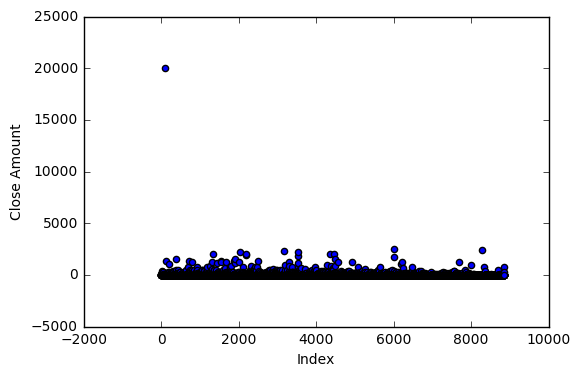

In [3]:
count = 0 # For updating values
index_arr = []

for claim in data.iterrows():
    close_amount = claim[1]["Close Amount"]
    # If the amount is not available...
    if not isinstance(close_amount, int):
        # Set it to 0
        data.set_value(count, "Close Amount", 0)
    index_arr.append(count)
    count = count + 1

data.loc[:, "Index"] = np.arange(8855)

# Calling .close() ensures that any instances of the plt that are running in the background are closed out
plt.close()

data.plot(kind="scatter", x="Index", y="Close Amount")

plt.show()

So we have our scatter plot, but it's not very pretty or readable. Luckily there are ways to make it better. Let's try to make a bar graph instead with ranges instead of plotting each data point.

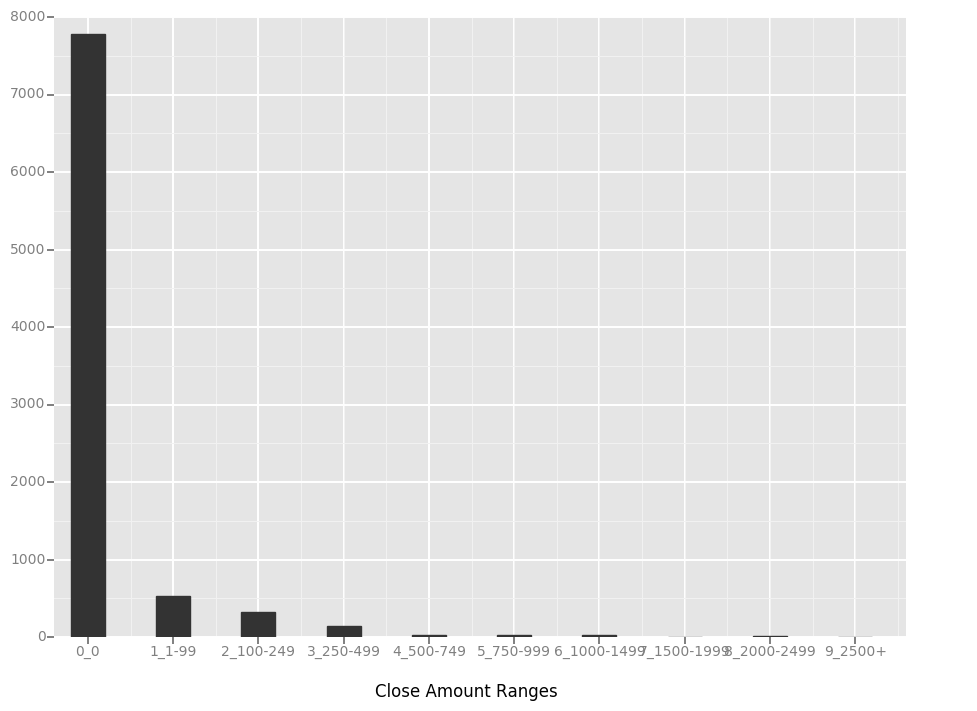

<ggplot: (293260152)>

In [4]:
# Let's instantiate counter variables for some ranges
zero = 0
one_100 = 0
two_250 = 0
three_500 = 0
four_750 = 0
five_1000 = 0
six_1500 = 0
seven_2000 = 0
eight_2500 = 0
nine_2500p = 0

# We have to iterate through the close amounts again to sort them into our ranges
for claim in data.iterrows():
    close_amount = claim[1]["Close Amount"]
    if close_amount == 0:
        zero = zero + 1
    elif close_amount >= 1 and close_amount < 100:
        one_100 = one_100 + 1
    elif close_amount >= 1 and close_amount < 250:
        two_250 = two_250 + 1
    elif close_amount >= 250 and close_amount < 500:
        three_500 = three_500 + 1
    elif close_amount >= 500 and close_amount < 750:
        four_750 = four_750 + 1
    elif close_amount >= 750 and close_amount < 1000:
        five_1000 = five_1000 + 1
    elif close_amount >= 1000 and close_amount < 1500:
        six_1500 = six_1500 + 1
    elif close_amount >= 1500 and close_amount < 2000:
        seven_2000 = seven_2000 + 1
    elif close_amount >= 2000 and close_amount < 2500:
        eight_2500 = eight_2500 + 1
    else:
        nine_2500p = nine_2500p + 1
        
ranges = [zero, one_100, two_250, three_500, four_750, five_1000, six_1500, seven_2000, eight_2500, nine_2500p]

# Due to ggplot sorting asciibetically, I prepended each string below with increasing numbers
# If this is not done, the bars will be in asciibetical order, which is counter intuitive
# Hopefully there is a more elegant solution out there, but 95% of the documentation for
# ggplot is specifically for R and does not carry over to Python.
x_values = ["0_0","1_1-99", "2_100-249", "3_250-499","4_500-749","5_750-999","6_1000-1499","7_1500-1999","8_2000-2499","9_2500+"]

df = pd.DataFrame({"Close Amount Ranges":x_values, "Count":ranges})

ggplot(aes(x="Close Amount Ranges",weight="Count"),df) + geom_bar(width=0.4)

So now we have a bar chart showing the number of close amounts that match the listed ranges. However, the other bars are dwarfed by the amount of close amounts that were rejected, resulting in an amount of 0. This graph gives us context in terms of how many claims were rejected by the TSA, but if we really want to see the distribution of claim amounts that were approved, we can simply remove the 0 counts from our graph to get something a bit more readable. The following code will regraph the data without the rejected claims: 

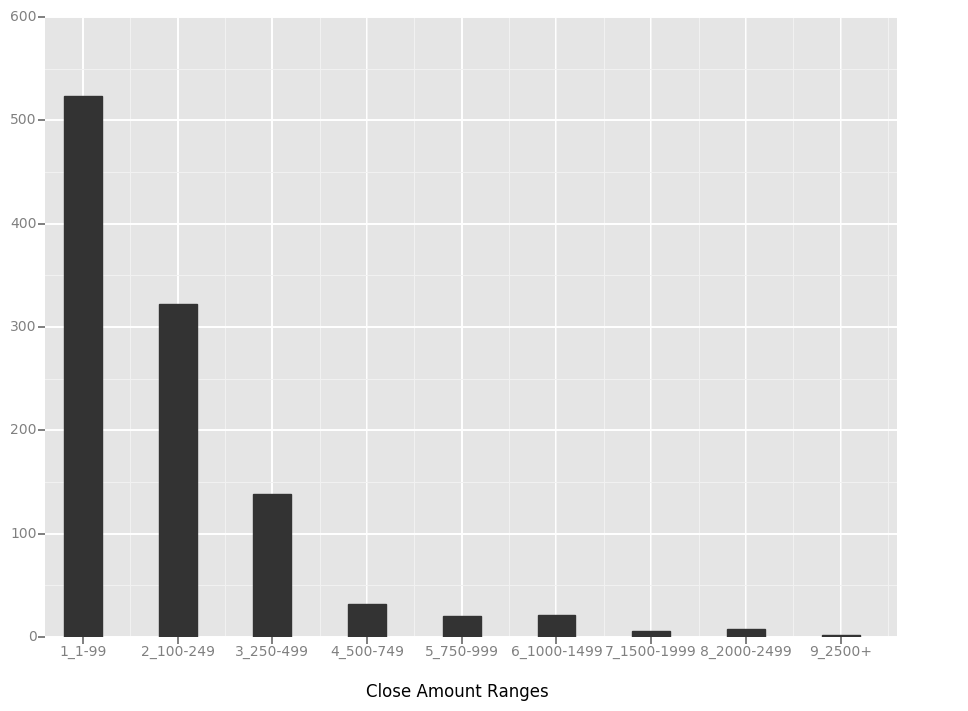

<ggplot: (-9223372036561490102)>

In [5]:
# Slice out the first value from the arrays.
ranges = ranges[1:]
x_values = x_values[1:]

# Instantiate a new dataframe
df = pd.DataFrame({"Close Amount Ranges":x_values, "Count":ranges})

ggplot(aes(x="Close Amount Ranges",weight="Count"),df) + geom_bar(width=0.4)

Alright, now we can actually see some detail in the close amounts. The data looks like what we would expect too: a larger percentage of the close amounts are in the sub \$250 range. Once you get above $499, the number of payouts drops off, with less than 25 payouts for the remaining ranges. Next let's take a look at plotting the number of claims on an interactive map using Folium.

## Plotting using Folium and Geopy

In order to do this, we'll need to get the longitude and latitudes of each of the airports. To do this, we will be using geopy to search for the airports based on their name's in the data, and then finding their longitude and latitude. We will then take the longitude and latitude and place a marker on our Folium map. I will break the code up into sections below.

### Note: 
In order to query geopy continuously, you must have a stable internet connection. It does not have to be fast, but if it drops out for more than a fraction of a second, you will get a time out error. I was not able to run the following code without making sure nothing was downloading/streaming in the background. Once everything else was closed, the queries went through just fine.

In [16]:
# First we set up the folium map
map_osm = folium.Map(location=[48, -102], zoom_start=3)

# and a dictionary to store the airport codes and their coordinates
code_to_coord = {}

# Then we get to iterate through all of the claims again
unknown = 0
na = 0

start = 0
end = 100

while end < 8857:
    for claim in data[start:end].iterrows():
        airport_name = claim[1]["Airport Name"]
        airport_code = claim[1]["Airport Code"]

        if airport_code not in code_to_coord:

            if "TSA" in airport_name:
                unknown = unknown + 1
            elif "Unspecified" in airport_name:
                unknown = unknown + 1
            elif "-" is airport_name:
                unknown = unknown + 1
            elif "Foreign" in airport_name:
                na = na + 1
            else:
                if "Sitka" in airport_name:
                    coord = (57.0527, -135.3651)
                elif "Baltimore/" in airport_name:
                    coord = (39.1774, -76.6684)
                elif "St. Petersburg-Clearwater" in airport_name:
                    coord = (27.9100, -82.6894)
                elif "Cyril E. King" in airport_name:
                    coord = (18.3361, -64.9723)
                elif "Boise Air Terminal" in airport_name:
                    coord =(43.5658,-116.2223)
                elif "Long Island McArthur" in airport_name:
                    coord = (40.7898, -73.0976)
                elif "Harrison Marion" in airport_name:
                    coord = (39.3007,-80.2259)
                elif "Dane County Regional" in airport_name:
                    coord = (43.1391,-89.3364)
                elif "Tyler Pounds Field" in airport_name:
                    coord = (32.3400,-95.4000)
                elif "Dickinson Theodore Roosevelt" in airport_name:
                    coord = (46.8017,-102.7929)
                elif "Lehigh Valley International" in airport_name:
                    coord = (40.6516,-75.4441)
                elif "Akron-Canton" in airport_name:
                    coord = (40.9146,-81.4367)
                elif "Rhinelander-Oni" in airport_name:
                    coord = (45.6366,-89.4121)
                elif "Quad City (Moline)" in airport_name:
                    coord = (41.4496,-90.5083)
                elif "Central Wisconsin" in airport_name:
                    coord = (44.7842, -89.6729)
                elif "Ft. Wayne Municipal" in airport_name:
                    coord = (40.9865,-85.1879)
                elif "Grand Forks - Mark" in airport_name:
                    coord = (47.9429, -97.1766)
                elif "Kileen" in airport_name:
                    coord = (31.0671,-97.8280)
                elif "Sheppard AFB/Wi" in airport_name:
                    coord = (33.9686,-98.5107)
                elif "Elmira Corning" in airport_name:
                    coord = (42.1599,-76.8936)
                elif "Glacier Park Int" in airport_name:
                    coord = (48.3099, -114.2546)
                elif "Newport News" in airport_name:
                    coord = (37.1317, -76.4928)
                elif "Albert J Ellis" in airport_name:
                    coord = (34.8284, -77.6122)
                elif "Joslin Field Magic" in airport_name:
                    coord = (42.4833,-114.4847)
                elif "Chisolm-Hibbing" in airport_name:
                    coord = (47.3922,-92.8421)
                else:
                    # Look up the location
                    geolocator = Nominatim()
                    loc = geolocator.geocode(airport_name)
                    try:
                        coord = loc.latitude, loc.longitude
                    except:
                        coord = (0,0)

                code_to_coord[airport_code] = coord
    start = start + 100
    end = end + 100
print(code_to_coord)

{'CAK': (40.9146, -81.4367), 'YUM': (32.6640609, -114.6023697), 'YAK': (59.6391781, -139.3429438), 'ANC': (61.18097005, -149.9853378713), 'FLL': (26.072017, -80.1509966313521), 'FLG': (35.14039825, -111.670204317811), 'CLE': (41.40661855, -81.8512020435841), 'GLH': (33.4828384, -90.9846788), 'PVD': (41.7274007, -71.4420736), 'STL': (38.74960255, -90.3702193368197), 'MCO': (28.41290355, -81.3094429975275), 'ACT': (31.6133017, -97.2263860620854), 'IDA': (43.5151828, -112.066210418897), 'FAT': (36.77616835, -119.719956716463), 'RDU': (35.88036145, -78.7872381171651), 'DCA': (38.8512154, -77.0396929556152), 'TRI': (36.47345205, -82.4084424677972), 'GJT': (39.1234158, -108.524449103066), 'SJU': (18.44319945, -65.9974302684747), 'GCC': (44.2906347, -105.5018758), 'PWM': (43.6461777, -70.3144194636337), 'JBR': (35.8315924, -90.6480401), 'CLL': (30.5880003, -96.3602267101522), 'BJI': (47.478654, -94.8908019), 'YKM': (0, 0), 'JFK': (40.6429479, -73.7793732748521), 'FAR': (46.9208925, -96.814487

The above code is a bit messy due to geopy missing the mark with some of the airport names, and the TSA not recording the names in a clear format, so there are a number of special cases. However we do end up with a dictionary containing all of the airport codes and their locations. We will have to double check geopy's results once we start mapping them on folium in case any of the locations look out of place, and I'm sure some will. The next piece of information we want is how many claims were filed for each airport. Luckily this code is much simpler than the above code. In fact, when we found out that JFK had the most claims, we created a dictionary with all of the counts already: claim_counts. So we can jump right into adding markers.

In [23]:
for code in code_to_coord:
    temp_count = claim_counts[code]
    
    popup_str = code + " | " + str(temp_count)
    
    folium.Marker(location = [code_to_coord[code][0], code_to_coord[code][1]],popup=popup_str,
                 icon = folium.Icon(color="red")).add_to(map_osm)
    
# Display the map
map_osm

## Evaluating the Map

So right off the bat we can see that geopy unfortunately missed the mark for a few of the airports since we shouldn't have any non-American airports marked on the map. These could be cleaned up by going through and manually adjusting their coordinates, but I'll leave that for any adventurous readers. The markers are set up so when you click on them, the pop up includes the airport code and the number of claims filed at that airport.

## Exploratory Data Analysis: Finding a Fit for Number of Claims

Now onto something a little different. Which airport do you think had the highest number of claims per number of passengers passing through it? Let's find out!

In order to do this, we'll need to get the data for the number of passengers in each airport. Luckily, the FAA is there for us. The data for the busiest US airports can be found here: https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/. You can download the spreadsheet in the Excel format for the 2015 calendar year since it has a column for 2014's enplanements to calculate % Change. Once that is downloaded and opened, we can pull the data and use it in our regression.

## Hypothesis: As Enplanements Go Up, Do Claims?

I think it's reasonable to guess that as an airport sees more traffic, there will be a linear increase in claims. We can find this out by finding our fit using a linear regression and then performing an ordinary least squares (or OLS) regression model.

In order to figure out a fit, we're going to calculate a linear regression by using the sklearn linear model. But first we have to load up the other excel file and match up the data with the airports. Follow the code belong to do just that.

In [26]:
faa = pd.read_excel("cy15-all-enplanements.xlsx")

faa.head()

,Rank,RO,ST,Locid,City,Airport Name,S/L,Hub,CY 15 Enplanements,CY 14 Enplanements,% Change
0,56,AL,AK,ANC,Anchorage,Ted Stevens Anchorage International,P,M,2525893,2381826,0.0605
1,121,AL,AK,FAI,Fairbanks,Fairbanks International,P,S,493443,459769,0.0732
2,132,AL,AK,JNU,Juneau,Juneau International,P,S,403538,375828,0.0737
3,196,AL,AK,BET,Bethel,Bethel,P,N,158824,155936,0.0185
4,212,AL,AK,KTN,Ketchikan,Ketchikan International,P,N,124747,115948,0.0759


Alright, we can see it's sorted alphabetically by state, then business, however that won't matter much to us since we're just using it to pull out some data.

In [31]:
# Dictionary for airport codes to enplanements
code_to_enp = {}

for airport in faa.iterrows():
    code = airport[1]["Locid"]
    if code in claim_counts:
        code_to_enp[code] = airport[1]["CY 14 Enplanements"]

Now that we have our code_to_enp dictionary loaded up, we can begin the linear regression on the data sets.

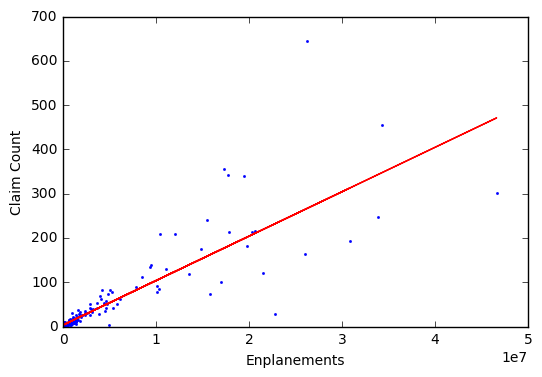

                            OLS Regression Results                            
Dep. Variable:                 values   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     826.0
Date:                Thu, 18 May 2017   Prob (F-statistic):           1.65e-87
Time:                        23:07:51   Log-Likelihood:                -1491.8
No. Observations:                 297   AIC:                             2988.
Df Residuals:                     295   BIC:                             2995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.5280      2.316      1.524      0.1

In [50]:
# The data we will be using just has to be combined into one dictionary:
enp_to_claims = {}

keys =[]
values = []

for code in code_to_enp:
    t_enp = code_to_enp[code]
    t_claims = claim_counts[code]
    
    keys.append(t_enp)
    values.append(t_claims)
    
    enp_to_claims[t_enp] = t_claims
# The linear regression model requires reshaped series objects
s_keys = pd.Series(keys)
s_values = pd.Series(values)

# The reshaping
x = s_keys.reshape(-1,1)
y = s_values.reshape(-1,1)

lm = LinearRegression()
lm.fit(x,y)

# Here we will begin setting up the plot
plt.close()
fig, ax1 = plt.subplots()
ax1.set_ylabel('Claim Count')
ax1.set_xlabel('Enplanements')
ax1.plot(x,y, color='blue', marker='.',linestyle='None',markersize='3')
ax1.plot(keys, lm.predict(x),color='red',markersize='3')
plt.show()
plt.close()

# Instantiate new dataframe for the OLS
reg_df = pd.DataFrame()
reg_df['keys'] = keys
reg_df['values'] = values

mod = sm.ols('values ~ (keys)',data=reg_df).fit()

print(mod.summary())

## OLS and Linear Regression Analysis

Above we can see our linear regression plotted out along with the ordinary least squares readout beneath it. We have an R-squared value of 0.737 which is lower than I would've expected. It is not high enough to conclusively say that there is a linear increase in claim counts as enplanements go up. According to our line, it looks like for every 99,700 (1/(1.003e-05)) enplanements, we can expect to see 1 additional claim. So the chances of an airport damaging or losing your property is almost 1 in 100,000. All things considered, this isn't too bad. However, due to the relatively low R-squared, we know that there are some airports out there that are both better and worse than they should be. For example, the busiest airport was Hartsfield-Jackson Atlanta International, so the right most dot represents them. We can see that they are quite a bit below the regression line, meaning that they have far fewer claims than we would expect, so there must be something different in Atlanta when it comes to taking care of their passengers' luggage. On the other hand, LAX was the 2nd busiest, but lost/damaged more luggage than is to be expected, meaning they take less care of their passengers' luggage, so if you travel through LAX, make sure any valuables are insured.

## Hypothesis Result

Due to the low R-squared value, I would reject my hypothesis that there is a linear fit. There seems to be a lot of variance in the data points, and while the line is a moderately good fit, I don't believe it comes close enough to be statistically significant. Delving deeper into the data, we may be able to discover some other correlation that may be a better fit, such as the % change in traffic for an airport. Maybe a sudden influx in traffic left the airport short staffed so more luggage was lost or damaged. But that is a project for another day.

## Summary

I hope this tutorial was a helpful look into the data science pipeline. The tools and methods used in this tutorial apply to any dataset you can find online, and I encourage you to go give it a try on a different set to see what you can find out. Each section in this tutorial could easily have a tutorial on its own, so if you have any interest in diving deeper into anything, I highly recommend you check out the documentation and other external links at the top of the page.